#  Xception : Images - Iteration #4_3(Without Data Augementation)

img_rows = 299 <br>
img_cols = 299 <br>
batch_size = 64 <br>
epochs = 50 <br>
Train set size = 67933 <br>
Valid set size = 16983 <br>
<font color = 'red'> Without Fine tuning , just LR 0.001 to 1e-5 </font>

**<u>Results</u>**

Accuracy : 0.62 <br>
F1 score weighted : 0.61

**Import packages**

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import re
tqdm_notebook.pandas()
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import pickle
from joblib import dump, load

# Iteration #4_3 - Xception

***Read DataFrame from saved pickele file - image Train set***

In [2]:
#Load df of images already resized on 256 x 256 
#df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_19102021.pkl")

#Load df of images with org size 500 x 500
df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_ORG_im_size_02122021.pkl")

In [3]:
df_train_im.head()

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,image_1077757786_product_278535884.jpg


In [4]:
display(df_train_im.shape)

(84916, 6)

***Create Dataframe containing  product classes and their associated labels***

In [5]:
#Dictionary of prdtypecode and their corresponding categories
dict_prdtypecode = {"prdtypecode" : [50, 2705, 2522, 2582, 1560, 1281, 1920, 1280, 1140, 1300, 2060, 2583,
                                     60, 1320, 2280, 1302, 2220, 40, 2905, 2585, 1940, 1160, 1301, 10, 1180,
                                     2403, 2462],                 
            
                    "Label" : ["video games accessories", "books", "stationery", "kitchen and garden", 
                               "interior furniture and bedding", "board games", "interior accessories",
                               "toys for children","goodies", "remote controlled models", "decoration interior",
                               "piscine spa","games and consoles", "early childhood", "magazines", "kids toys",
                               "supplies for domestic animals", "imported video games", "online distribution of video games",
                               "gardening and DIY","Food","playing cards", "accessories children", "adult books",
                               "figurines_wargames", "children books",
                                "games"]
                   }
df_class = pd.DataFrame(data=dict_prdtypecode)
df_class

,prdtypecode,Label
0,50,video games accessories
1,2705,books
2,2522,stationery
3,2582,kitchen and garden
4,1560,interior furniture and bedding
5,1281,board games
6,1920,interior accessories
7,1280,toys for children
8,1140,goodies
9,1300,remote controlled models


In [6]:
# Crate DF containing prdtypecode , categories and corresponding class used by model
df_class = df_class.sort_values(by = 'prdtypecode', ascending = True)
df_class['target_prdtypecode'] = [i for i in range(27)]
df_class

,prdtypecode,Label,target_prdtypecode
23,10,adult books,0
17,40,imported video games,1
0,50,video games accessories,2
12,60,games and consoles,3
8,1140,goodies,4
21,1160,playing cards,5
24,1180,figurines_wargames,6
7,1280,toys for children,7
5,1281,board games,8
9,1300,remote controlled models,9


***Change the 27 product codes to 0 to 26***

In [7]:
df_train_im.replace({'prdtypecode':{10:0,
                                    40:1,
                                    50:2,
                                    60:3,
                                    1140:4,
                                    1160:5,
                                    1180:6,
                                    1280:7,
                                    1281:8,
                                    1300:9                                    
                                    }}, inplace = True)

df_train_im.replace({'prdtypecode':{1301:10,
                                    1302:11,
                                    1320:12,
                                    1560:13,
                                    1920:14,
                                    1940:15,
                                    2060:16,
                                    2220:17,
                                    2280:18,
                                    2403:19,
                                    2462:20,
                                    2522:21,
                                    2582:22,
                                    2583:23,
                                    2585:24,
                                    2705:25,
                                    2905:26
                                    }}, inplace = True)

In [8]:
display(df_train_im["prdtypecode"].unique())

array([ 0, 18,  2,  7, 25, 21, 22, 13,  8, 14, 19,  4, 23,  6,  9, 20,  5,
       16,  1,  3, 12, 11, 17, 26, 24, 15, 10], dtype=int64)

 ***Convert product code to string type***

In [9]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

In [10]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

{'0': 3116,
 '1': 2508,
 '10': 807,
 '11': 2491,
 '12': 3241,
 '13': 5073,
 '14': 4303,
 '15': 803,
 '16': 4993,
 '17': 824,
 '18': 4760,
 '19': 4774,
 '2': 1681,
 '20': 1421,
 '21': 4989,
 '22': 2589,
 '23': 10209,
 '24': 2496,
 '25': 2761,
 '26': 872,
 '3': 832,
 '4': 2671,
 '5': 3953,
 '6': 764,
 '7': 4870,
 '8': 2070,
 '9': 5045}

 ***Split Train Set***

In [11]:
# Split Train set 
#X_train_im, X_test_im = train_test_split(df_train_im, train_size=0.8, random_state=1234)

In [12]:
#display(X_train_im.shape)
#display(X_test_im.shape)

***Data Generator***

In [13]:
%%time
#Générateur de données
img_gen = ImageDataGenerator(rescale = 1/255, 
                             validation_split = 0.2)

Wall time: 0 ns


In [14]:
img_rows = 299
img_cols = 299
batch_size = 64
epochs = 50

# Directory of images already resized on 256 x 256 
#images_dir_train = './data/images/all/image_train_resized/'
#images_dir_train = 'E:/WorkSpace_DataScience_E/Rakuten_Projet_Local/My_WS/data/images/all/image_train_resized/'

# Directory of images org resize 500 x 500
images_dir_train = './data/images/all/image_train/'
#images_dir_train = 'E:/WorkSpace_DataScience_E/Rakuten_Projet_Local/My_WS/data/images/all/image_train/'

In [15]:
%%time

#Itérateur 
train_generator = img_gen.flow_from_dataframe(dataframe = df_train_im,
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True, # défault
                                              subset = 'training'
                                             )

Found 67933 validated image filenames belonging to 27 classes.
Wall time: 6.82 s


In [16]:
%%time
# validation_split the validation batches ca be retrieved by specifying the subset as validation.
valid_generator = img_gen.flow_from_dataframe(dataframe = df_train_im, 
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False,
                                              subset  = 'validation'
                                             )

Found 16983 validated image filenames belonging to 27 classes.
Wall time: 5.72 s


 ***Xception Implementation***

In [17]:
%%time
# Chargement du modèle Xception
xception = Xception(weights='imagenet', include_top = False, input_shape=(img_rows,img_rows,3))

# Bloquage du blackbone
for layer in xception.layers:
    layer.trainable = False
    
model = Sequential()
model.add(xception)
# Ajout des couche de classification
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024,activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 512, activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 27, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1

 ***Compilation***

In [19]:
%%time
# Compilation
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer= Adam(learning_rate= 1e-5) ,   #default lr = 0.001 # algorithme de descente de gradient
              metrics=['accuracy'])                    # métrique d'évaluation

Wall time: 5 ms


***Callbacks***

In [20]:
%%time
path = './saves/Xception/Iteration_4_3/'
file_name = 'checkpoint_Xception_21122021_299x299_50Epochs.h5'

#Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :
checkpoint = ModelCheckpoint(filepath = path + file_name , 
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', #(permet de préciser si la métrique doit croître ou décroitre : ici on choisit 'min'
                                           #car la métrique est une perte à minimiser)
                             save_freq='epoch')
#Arrêter l'entraînement si le modèle n'évolue plus (très pratique pour ne pas gérer le
#nombre d'epoch) :
early = EarlyStopping(monitor='val_loss',
                      min_delta = 0,
                      patience = 10, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,
                      verbose = 1,
                      mode = 'min')

#Réduire automatiquement le learning rate :
lr_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                               patience = 10,
                               verbose = 1,
                                mode='min'
                               )

Wall time: 0 ns


 ***Fit - train_generator***

In [21]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  1061
step_size_Valid  :  265


In [23]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    callbacks=[checkpoint, early, lr_plateau]                    
                    )

Epoch 1/50
1061/1061 [==============================] - 305s 287ms/step - loss: 1.4379 - accuracy: 0.5686 - val_loss: 1.4576 - val_accuracy: 0.5642

Epoch 00001: val_accuracy improved from 0.55820 to 0.56415, saving model to ./saves/Xception/Iteration_4_3\checkpoint_Xception_21122021_299x299_50Epochs.h5
Epoch 2/50
1061/1061 [==============================] - 304s 286ms/step - loss: 1.4213 - accuracy: 0.5740 - val_loss: 1.4465 - val_accuracy: 0.5655

Epoch 00002: val_accuracy improved from 0.56415 to 0.56551, saving model to ./saves/Xception/Iteration_4_3\checkpoint_Xception_21122021_299x299_50Epochs.h5
Epoch 3/50
1061/1061 [==============================] - 304s 287ms/step - loss: 1.4033 - accuracy: 0.5779 - val_loss: 1.4390 - val_accuracy: 0.5680

Epoch 00003: val_accuracy improved from 0.56551 to 0.56798, saving model to ./saves/Xception/Iteration_4_3\checkpoint_Xception_21122021_299x299_50Epochs.h5
Epoch 4/50
1061/1061 [==============================] - 304s 286ms/step - loss: 1.388

1061/1061 [==============================] - 305s 287ms/step - loss: 1.1234 - accuracy: 0.6589 - val_loss: 1.3225 - val_accuracy: 0.6028

Epoch 00028: val_accuracy improved from 0.60254 to 0.60277, saving model to ./saves/Xception/Iteration_4_3\checkpoint_Xception_21122021_299x299_50Epochs.h5
Epoch 29/50
1061/1061 [==============================] - 304s 287ms/step - loss: 1.1144 - accuracy: 0.6610 - val_loss: 1.3183 - val_accuracy: 0.6051

Epoch 00029: val_accuracy improved from 0.60277 to 0.60507, saving model to ./saves/Xception/Iteration_4_3\checkpoint_Xception_21122021_299x299_50Epochs.h5
Epoch 30/50
1061/1061 [==============================] - 305s 287ms/step - loss: 1.1030 - accuracy: 0.6636 - val_loss: 1.3176 - val_accuracy: 0.6045

Epoch 00030: val_accuracy did not improve from 0.60507
Epoch 31/50
1061/1061 [==============================] - 304s 287ms/step - loss: 1.0971 - accuracy: 0.6643 - val_loss: 1.3164 - val_accuracy: 0.6050

Epoch 00031: val_accuracy did not improve fro

***Save History results***

In [24]:
# Save History results
path = './saves/Xception/Iteration_4_3/'
filename = 'history_Xception_all_train_21122021_299x299_50Epochs'

In [25]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# history to json:  
hist_json_file = path + filename + '.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# history to csv: 
hist_csv_file = path + filename +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# history to pickle file
hist_df.to_pickle(path + filename +'.pkl')

***Display Model loss , accuracy per epoch***

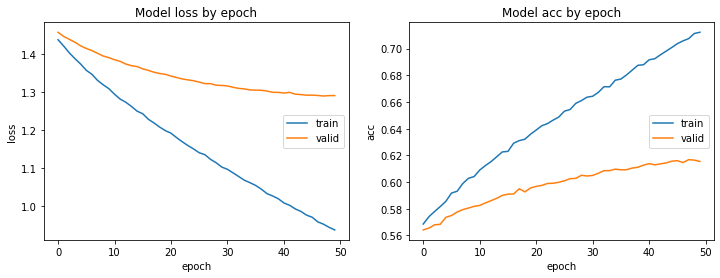

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

 ***Prediction - test_generator***

In [27]:
%%time
#Prediction - Valid set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from test generator
y_true = valid_generator.classes

Wall time: 56.7 s


 ***Evaluation - test_generator***

In [28]:
%%time
#Get the accuracy score
valid_score = model.evaluate(valid_generator)
print("[INFO] Model metrics names:", model.metrics_names)
print("[INFO] Accuracy: {:.2f}%".format(valid_score[1] * 100)) 
print("[INFO] Loss: ",valid_score[0])

266/266 [==============================] - 58s 218ms/step - loss: 1.2906 - accuracy: 0.6156
[INFO] Model metrics names: ['loss', 'accuracy']
[INFO] Accuracy: 61.56%
[INFO] Loss:  1.2906032800674438
Wall time: 58.6 s


In [29]:
f1_macro = f1_score(y_true, y_pred_class, average='macro')
print("[INFO] f1 score macro average: ",f1_macro)

f1_micro = f1_score(y_true, y_pred_class, average='micro')
print("[INFO] f1 score micro average: ",f1_micro)

f1_weighted = f1_score(y_true, y_pred_class, average='weighted')
print("[INFO] f1 score weighted average: ",f1_weighted)

[INFO] f1 score macro average:  0.5603031236882271
[INFO] f1 score micro average:  0.6156156156156156
[INFO] f1 score weighted average:  0.6068650324594033


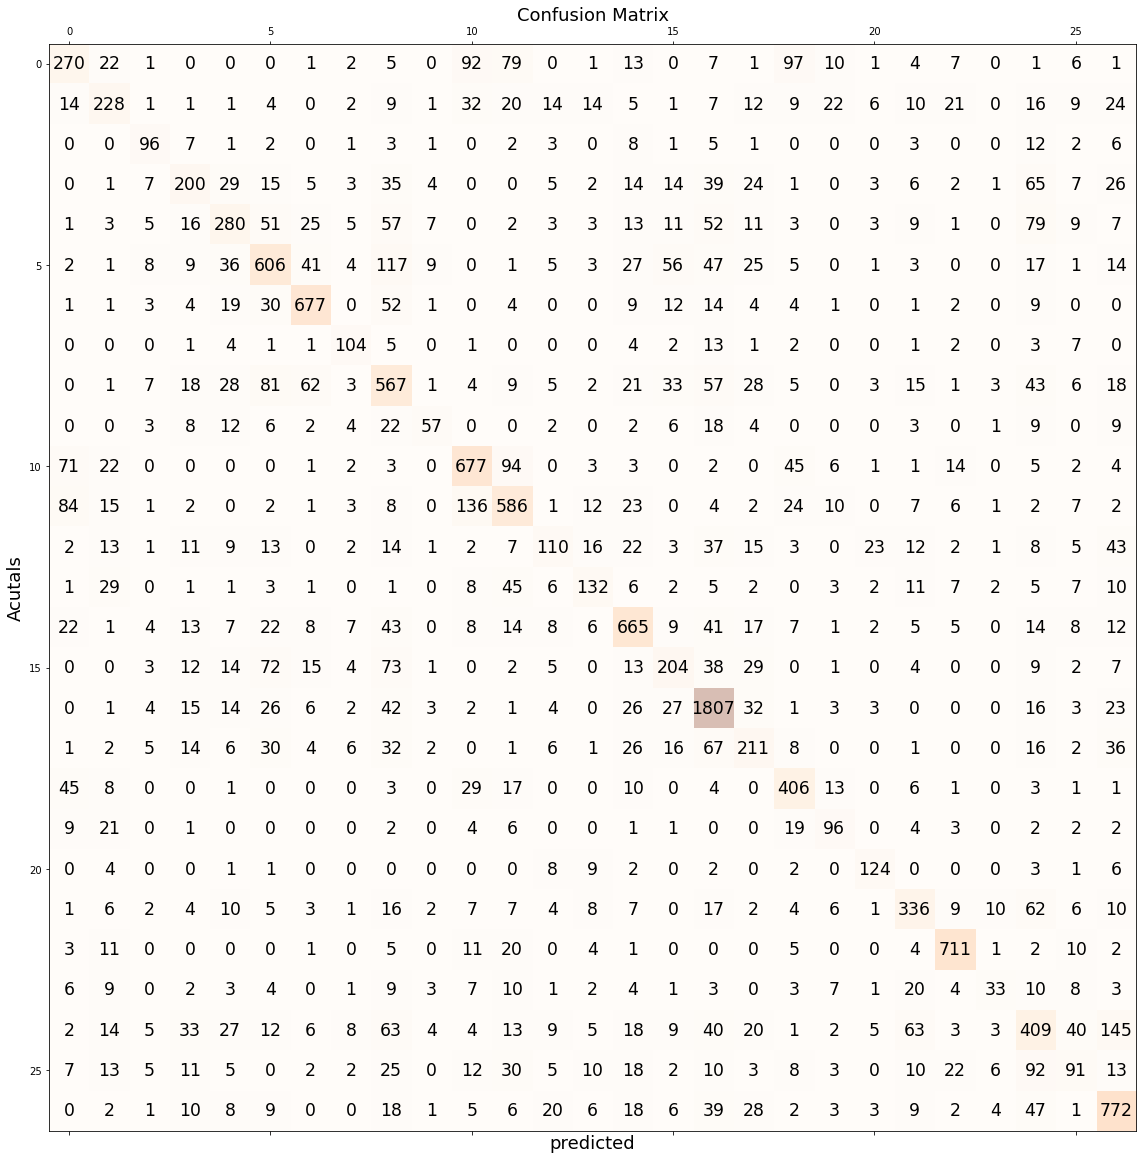

In [30]:
#Confusion matrix
matrix = confusion_matrix(y_true, y_pred_class)
fig , ax = plt.subplots(figsize = (24,20))
ax.matshow(matrix, cmap = plt.cm.Oranges , alpha = 0.3)
for i in range(matrix.shape[0]):
    for j in range (matrix.shape[1]):
        ax.text (x = j , y= i, s= matrix[i,j], va = 'center', ha = 'center', size = 'xx-large')
        
plt.xlabel('predicted', fontsize = 18)
plt.ylabel('Acutals', fontsize = 18)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()
#print(matrix)

In [31]:
print(metrics.classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46       621
           1       0.53      0.47      0.50       483
           2       0.59      0.62      0.61       154
           3       0.51      0.39      0.44       508
           4       0.54      0.43      0.48       656
           5       0.61      0.58      0.60      1038
           6       0.79      0.80      0.79       848
           7       0.63      0.68      0.65       152
           8       0.46      0.56      0.50      1021
           9       0.58      0.34      0.43       168
          10       0.65      0.71      0.68       956
          11       0.60      0.62      0.61       939
          12       0.49      0.29      0.37       375
          13       0.55      0.46      0.50       290
          14       0.68      0.70      0.69       949
          15       0.49      0.40      0.44       508
          16       0.76      0.88      0.81      2061
          17       0.45    

 ***Predict input image using trained model***

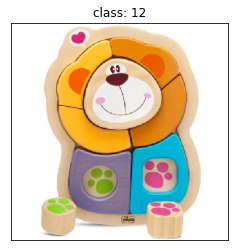

In [32]:
# Predict With Pre Trained

# Load an image
im_id = 124
img_path ='./data/images/all/image_train/'+ df_train_im['imagePath'][im_id]

img = image.load_img(img_path,target_size=(299, 299))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][im_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [33]:
im = cv2.resize(cv2.imread(img_path), (299, 299))
im = np.expand_dims(im, axis=0)

In [34]:
out = model.predict(im)
print("------------------Predicted Class and Label ------------------------------")
print("target class(used by model) :", np.argmax(out))
print("\n"  ,df_class[df_class['target_prdtypecode'] == np.argmax(out)][['prdtypecode', 'Label']].to_string(index=False)) 

prd_code = df_train_im['prdtypecode'][im_id]

print("\n\n------------------Real Class and Label ------------------------------")
print("target class(used by model): " ,  df_class[df_class['target_prdtypecode'] == int(prd_code)]['target_prdtypecode'].to_string(index=False))
print("\n"  ,df_class[df_class['target_prdtypecode'] == int(prd_code)][['prdtypecode', 'Label']].to_string(index=False))

------------------Predicted Class and Label ------------------------------
target class(used by model) : 14

  prdtypecode                Label
        1920 interior accessories


------------------Real Class and Label ------------------------------
target class(used by model):  12

  prdtypecode           Label
        1320 early childhood


 ***Save Xception Model***

In [36]:
#Enregistrement du modèle
model.save("./saves/Xception/Iteration_4_3/Model_xception_All_train_data_21122021_299x299_50Epochs.hdf5")
#The SavedModel and HDF5 file contains:
#the model's configuration (topology)
#the model's weights
#the model's optimizer's state (if any)

 ***Load Xception Model***

In [ ]:
#Rechargement du modèle :
model = load_model('/saves/Xception/Iteration_4_3/Model_xception_All_train_data_21122021_299x299_50Epochs.hdf5')